In [32]:
import torch
import torchvision
from torchvision import transforms
import PIL
from PIL import Image
import os
import glob
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop

In [26]:
class cfg:
    data_dir = "/opt/ml/input/data/train/"
    img_dir = f"{data_dir}/images"
    df_path = f"{data_dir}/train.csv"
    img_height = 512
    img_width = 384

In [7]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal']
class2num = {k : v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [9]:
def get_ext(img_dir, img_id):
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    
    return ext

In [13]:
image_dirs=[]
for path in df.path:
    image_dirs.append(os.path.join(cfg.img_dir, path)) 

In [23]:
#mask labeling
imgs=[]
labels=[]
for path in image_dirs:
    for image in glob(f'{path}/**'):
        if 'normal' in image:
            labels.append(2)
        elif 'incorrect' in image:
            labels.append(1)
        else:
            labels.append(0)
        imgs.append(image)

In [24]:
class MaskDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        if self.transform:
            image=self.transform(image)
        return image
    
    def __len__(self):
        return len(self.img_paths)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


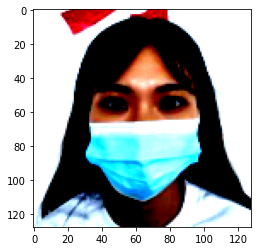

In [39]:
transform = transforms.Compose([
    Resize((int(cfg.img_height/2), int(cfg.img_width/2)),Image.BILINEAR),
    CenterCrop(int(cfg.img_height/4)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_dataset = MaskDataset(imgs, transform)
mask_dataloader = DataLoader(mask_dataset, shuffle=True)

batch_iterator = iter(mask_dataloader)
images = next(batch_iterator)
plt.imshow(torchvision.utils.make_grid(images, nrow=5).permute(1, 2, 0))
plt.show()